In [67]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
from sklearn.preprocessing import StandardScaler
import pandas as pd
from os import walk
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
model=tf.keras.applications.xception.Xception(weights='imagenet',include_top=True)
#Summary of Xception Model
print(model.summary())

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [3]:
pre_final_model = tf.keras.Model(model.input, model.get_layer("avg_pool").output)

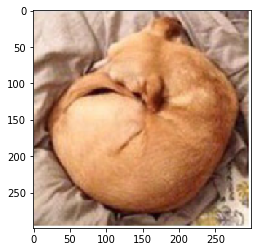

In [4]:
PJES_IMAGE_PATH='./pjes.png'
pjes_img=tf.keras.preprocessing.image.load_img(PJES_IMAGE_PATH,target_size=(299,299))
pjes_img=tf.keras.preprocessing.image.img_to_array(pjes_img)
#view the image
plt.imshow(pjes_img/255.)
pjes_img=tf.keras.applications.xception.preprocess_input(pjes_img)

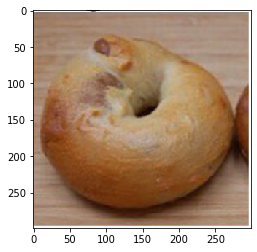

In [5]:
Bulka_IMAGE_PATH='./bulka.png'
bulka_img=tf.keras.preprocessing.image.load_img(Bulka_IMAGE_PATH,target_size=(299,299))
bulka_img=tf.keras.preprocessing.image.img_to_array(bulka_img)
plt.imshow(bulka_img/255.)
bulka_img=tf.keras.applications.xception.preprocess_input(bulka_img)

In [20]:
import requests
#fetching labels from Imagenet  
response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
imgnet_map=response.json()
imgnet_map={v[1]:k for k, v in imgnet_map.items()}

def get_prediction(filename):
    cur_img=tf.keras.preprocessing.image.load_img(filename,target_size=(299,299))
    cur_img=tf.keras.preprocessing.image.img_to_array(cur_img)
    cur_img=tf.keras.applications.xception.preprocess_input(cur_img)
    cur_predictions=model.predict(np.array([cur_img]))
    decoded = decode_predictions(cur_predictions,top=5)
    pre_final_predictions = pre_final_model.predict(np.array([cur_img]))
    return pre_final_predictions, decoded

In [11]:
predictions_pjes=model.predict(np.array([pjes_img]))
decode_predictions(predictions_pjes,top=5)

[[('n07693725', 'bagel', 0.12675144),
  ('n13044778', 'earthstar', 0.09523672),
  ('n07875152', 'potpie', 0.046712946),
  ('n07860988', 'dough', 0.034578137),
  ('n02395406', 'hog', 0.018144205)]]

In [9]:
pre_final_model.predict(np.array([pjes_img]))

array([[0.05384583, 0.        , 0.22001101, ..., 0.        , 0.        ,
        0.13771126]], dtype=float32)

In [10]:
predictions_bulka=model.predict(np.array([bulka_img]))
decode_predictions(predictions_bulka,top=5)

[[('n07693725', 'bagel', 0.9598253),
  ('n07695742', 'pretzel', 0.001848734),
  ('n02776631', 'bakery', 0.0006288528),
  ('n01968897', 'chambered_nautilus', 0.00045748946),
  ('n01945685', 'slug', 0.0003918472)]]

In [12]:
pre_final_model.predict(np.array([bulka_img]))

array([[0.0000000e+00, 7.5958058e-02, 1.5908062e-04, ..., 0.0000000e+00,
        0.0000000e+00, 6.2388605e-01]], dtype=float32)

In [83]:
def generate_plot(path, output_filename):
    results_dict = {"targets": []}
    targets_list = []
    
    #parse model data 
    for _, _, filenames in walk(path):
        for filename in filenames:
            pre_final, prediction = get_prediction(path+filename)
            for it, element in enumerate(np.nditer(pre_final.T), start=1):
                if not results_dict.get(f"feature_{it}"):
                    results_dict[f"feature_{it}"] = []
                results_dict[f"feature_{it}"].append(element)
            target = filename.split("-")[0]
            results_dict["targets"].append(target)
            if target not in targets_list:
                targets_list.append(target)
    features = list(results_dict.keys())
    features.remove("targets")
    
    #Create pandas data
    pd_results = pd.DataFrame.from_dict(results_dict)
    x = pd_results.loc[:, features].values
    y = pd_results.loc[:,['targets']].values
    x = StandardScaler().fit_transform(x)
    
    #Apply PCA
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    finalDf = pd.concat([principalDf, pd_results[['targets']]], axis = 1)
    
    #create plot
    ax = plt.axes(projection='3d')
    ax.set_title('3 component PCA', fontsize = 20)
    targets = targets_list
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['targets'] == target
        ax.scatter3D(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , finalDf.loc[indicesToKeep, 'principal component 3']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.savefig(output_filename +'.png')
    finalDf.to_csv(output_filename+".csv", index=False)

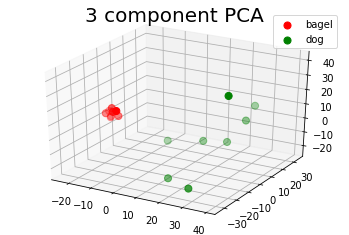

In [85]:
generate_plot("./deep-learning-datasets/dog-bagel/", "bajgl-out")

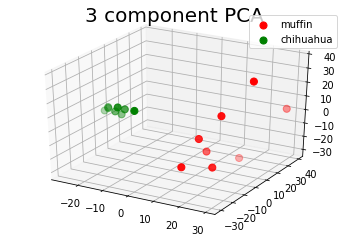

In [86]:
generate_plot("./deep-learning-datasets/chihuahua-muffin/", "chihuahua-out")